## Single Shot Detector for ExtremeWeather Data

### Preprocessing the Data
The [ExtremeWeather](https://extremeweatherdataset.github.io/) data set consists of weather data for a specific 25km region from 1979 to 2005. 
The data is organized by year and contains 4 images per day. Each image has 768x1152 pixels across 16 channels for different weather variables. 
In addition, each day has up to 15 bounding boxes
surrounding extreme weather events classified as Tropical Depression, Tropical Cyclone, Extratropical Cyclone, and Atmospheric River.

The goal is to correctly identify and classify extreme weather events. 
The first challenge is the sheer size of the data set.
Each year, even when compressed, takes 64 GB to store.
As the "small" data set, we consider 1979: we train on January through October, validate on November, and test on December.
We preprocess each year rescaling each image so its of size 300x300 and
choosing 3 of the 16 channels by hand for 'visual explainability' of bounding boxes.



### Set up

In [1]:
## Load data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Set up
### Loading Data
import random
import os
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image

### Visualization
from matplotlib import patches
import matplotlib.pyplot as plt

### Loss function
import itertools
import math
import torch.nn.functional as F
import torch.nn as nn

### Model
import numpy as np
import torch
import gc
import torch.nn as nn
from torch.autograd import Variable

### Training
import time

#### Ignore warnings
#import warnings
#warnings.filterwarnings("ignore")



### Box Encoder

One of the key insights of SSD is combining the predicted bounding boxes with the convolutional layers. The first step is to represent the ground truth bounding boxes in the higher dimensional space of the predicted bounding boxes. In particular, we consider 8732 possible bounding box positions in an image (at different aspect ratios, centers, and scales). Therefore we need to find the bounding boxes in this higher dimensional space most related to the ground truth bounding.

In [3]:
# https://github.com/kuangliu/torchcv/blob/master/torchcv/utils/meshgrid.py

def meshgrid(x, y, row_major=True):
    '''Return meshgrid in range x & y.
    Args:
      x: (int) first dim range.
      y: (int) second dim range.
      row_major: (bool) row major or column major.
    Returns:
      (tensor) meshgrid, sized [x*y,2]
    '''
    a = torch.arange(0,x)
    b = torch.arange(0,y)
    xx = a.repeat(y).view(-1,1)
    yy = b.view(-1,1).repeat(1,x).view(-1,1)
    return torch.cat([xx,yy],1) if row_major else torch.cat([yy,xx],1)

# https://github.com/kuangliu/torchcv/blob/master/torchcv/utils/box.py
def change_box_order(boxes, order):
    '''Change box order between (xmin,ymin,xmax,ymax) and (xcenter,ycenter,width,height).
    Args:
      boxes: (tensor) bounding boxes, sized [N,4].
      order: (str) either 'xyxy2xywh' or 'xywh2xyxy'.
    Returns:
      (tensor) converted bounding boxes, sized [N,4].
    '''
    assert order in ['xyxy2xywh','xywh2xyxy']
    a = boxes[:,:2]
    b = boxes[:,2:]
    if order == 'xyxy2xywh':
        return torch.cat([(a+b)/2,b-a], 1)
    return torch.cat([a-b/2,a+b/2], 1)

def box_clamp(boxes, xmin, ymin, xmax, ymax):
    '''Clamp boxes.
    Args:
      boxes: (tensor) bounding boxes of (xmin,ymin,xmax,ymax), sized [N,4].
      xmin: (number) min value of x.
      ymin: (number) min value of y.
      xmax: (number) max value of x.
      ymax: (number) max value of y.
    Returns:
      (tensor) clamped boxes.
    '''
    boxes[:,0].clamp_(min=xmin, max=xmax)
    boxes[:,1].clamp_(min=ymin, max=ymax)
    boxes[:,2].clamp_(min=xmin, max=xmax)
    boxes[:,3].clamp_(min=ymin, max=ymax)
    return boxes

def box_select(boxes, xmin, ymin, xmax, ymax):
    '''Select boxes in range (xmin,ymin,xmax,ymax).
    Args:
      boxes: (tensor) bounding boxes of (xmin,ymin,xmax,ymax), sized [N,4].
      xmin: (number) min value of x.
      ymin: (number) min value of y.
      xmax: (number) max value of x.
      ymax: (number) max value of y.
    Returns:
      (tensor) selected boxes, sized [M,4].
      (tensor) selected mask, sized [N,].
    '''
    mask = (boxes[:,0]>=xmin) & (boxes[:,1]>=ymin) \
         & (boxes[:,2]<=xmax) & (boxes[:,3]<=ymax)
    boxes = boxes[mask,:]
    return boxes, mask

def box_iou(box1, box2):
    '''Compute the intersection over union of two set of boxes.
    The box order must be (xmin, ymin, xmax, ymax).
    Args:
      box1: (tensor) bounding boxes, sized [N,4].
      box2: (tensor) bounding boxes, sized [M,4].
    Return:
      (tensor) iou, sized [N,M].
    Reference:
      https://github.com/chainer/chainercv/blob/master/chainercv/utils/bbox/bbox_iou.py
    '''
    N = box1.size(0)
    M = box2.size(0)

    lt = torch.max(box1[:,None,:2], box2[:,:2])  # [N,M,2]
    rb = torch.min(box1[:,None,2:], box2[:,2:])  # [N,M,2]

    wh = (rb-lt).clamp(min=0)      # [N,M,2]
    inter = wh[:,:,0] * wh[:,:,1]  # [N,M]

    area1 = (box1[:,2]-box1[:,0]) * (box1[:,3]-box1[:,1])  # [N,]
    area2 = (box2[:,2]-box2[:,0]) * (box2[:,3]-box2[:,1])  # [M,]
    iou = inter / (area1[:,None] + area2 - inter)
    return iou

def box_nms(bboxes, scores, threshold=0.5):
    '''Non maximum suppression.
    Args:
      bboxes: (tensor) bounding boxes, sized [N,4].
      scores: (tensor) confidence scores, sized [N,].
      threshold: (float) overlap threshold.
    Returns:
      keep: (tensor) selected indices.
    Reference:
      https://github.com/rbgirshick/py-faster-rcnn/blob/master/lib/nms/py_cpu_nms.py
    '''
    x1 = bboxes[:,0]
    y1 = bboxes[:,1]
    x2 = bboxes[:,2]
    y2 = bboxes[:,3]

    areas = (x2-x1) * (y2-y1)
    _, order = scores.sort(0, descending=True)

    keep = []
    while order.numel() > 0:
        i = order[0].item() if order.size() != torch.Size([]) else order.item()
        keep.append(i)

        if order.numel() == 1:
            break

        xx1 = x1[order[1:]].clamp(min=x1[i].item())
        yy1 = y1[order[1:]].clamp(min=y1[i].item())
        xx2 = x2[order[1:]].clamp(max=x2[i].item())
        yy2 = y2[order[1:]].clamp(max=y2[i].item())

        w = (xx2-xx1).clamp(min=0)
        h = (yy2-yy1).clamp(min=0)
        inter = w * h

        overlap = inter / (areas[i] + areas[order[1:]] - inter)
        ids = (overlap<=threshold).nonzero().squeeze()
        if ids.numel() == 0:
            break
        order = order[ids+1]
    return torch.tensor(keep, dtype=torch.long) 

# https://github.com/kuangliu/torchcv/blob/master/torchcv/models/ssd/box_coder.py
class SSDBoxCoder:
    def __init__(self, ssd_model):
        self.steps = ssd_model.steps
        self.box_sizes = ssd_model.box_sizes
        self.aspect_ratios = ssd_model.aspect_ratios
        self.fm_sizes = ssd_model.fm_sizes
        self.default_boxes = self._get_default_boxes()

    def _get_default_boxes(self):
        boxes = []
        for i, fm_size in enumerate(self.fm_sizes):
            for h, w in itertools.product(range(fm_size), repeat=2):
                cx = (w + 0.5) * self.steps[i]
                cy = (h + 0.5) * self.steps[i]

                s = self.box_sizes[i]
                boxes.append((cx, cy, s, s))

                s = math.sqrt(self.box_sizes[i] * self.box_sizes[i+1])
                boxes.append((cx, cy, s, s))

                s = self.box_sizes[i]
                for ar in self.aspect_ratios[i]:
                    boxes.append((cx, cy, s * math.sqrt(ar), s / math.sqrt(ar)))
                    boxes.append((cx, cy, s / math.sqrt(ar), s * math.sqrt(ar)))
        return torch.Tensor(boxes)  # xywh

    def encode(self, boxes, labels):
        '''Encode target bounding boxes and class labels.
        SSD coding rules:
          tx = (x - anchor_x) / (variance[0]*anchor_w)
          ty = (y - anchor_y) / (variance[0]*anchor_h)
          tw = log(w / anchor_w) / variance[1]
          th = log(h / anchor_h) / variance[1]
        Args:
          boxes: (tensor) bounding boxes of (xmin,ymin,xmax,ymax), sized [#obj, 4].
          labels: (tensor) object class labels, sized [#obj,].
        Returns:
          loc_targets: (tensor) encoded bounding boxes, sized [#anchors,4].
          cls_targets: (tensor) encoded class labels, sized [#anchors,].
        Reference:
          https://github.com/chainer/chainercv/blob/master/chainercv/links/model/ssd/multibox_coder.py
        '''
        def argmax(x):
            v, i = x.max(0)
            j = v.max(0)[1].item()
            return (i[j], j)

        default_boxes = self.default_boxes  # xywh
        default_boxes = change_box_order(default_boxes, 'xywh2xyxy')

        ious = box_iou(default_boxes, boxes)  # [#anchors, #obj]
        index = torch.LongTensor(len(default_boxes)).fill_(-1)
        masked_ious = ious.clone()
        while True:
            i, j = argmax(masked_ious)
            if masked_ious[i,j] < 1e-6:
                break
            index[i] = j
            masked_ious[i,:] = 0
            masked_ious[:,j] = 0

        mask = (index<0) & (ious.max(1)[0]>=0.5)
        if mask.any():
            squeezed_nonzero = mask.nonzero().squeeze()
            if torch.Size([]) == squeezed_nonzero.size():
              squeezed_nonzero = torch.stack([squeezed_nonzero])
            index[mask] = ious[squeezed_nonzero].max(1)[1]

        boxes = boxes[index.clamp(min=0)]  # negative index not supported
        boxes = change_box_order(boxes, 'xyxy2xywh')
        default_boxes = change_box_order(default_boxes, 'xyxy2xywh')

        variances = (0.1, 0.2)
        loc_xy = (boxes[:,:2]-default_boxes[:,:2]) / default_boxes[:,2:] / variances[0]
        loc_wh = torch.log(boxes[:,2:]/default_boxes[:,2:]) / variances[1]
        loc_targets = torch.cat([loc_xy,loc_wh], 1)
        cls_targets = 1 + labels[index.clamp(min=0)]
        cls_targets[index<0] = 0
        return loc_targets, cls_targets

    def decode(self, loc_preds, cls_preds, score_thresh=0.6, nms_thresh=0.45):
        '''Decode predicted loc/cls back to real box locations and class labels.
        Args:
          loc_preds: (tensor) predicted loc, sized [8732,4].
          cls_preds: (tensor) predicted conf, sized [8732,21].
          score_thresh: (float) threshold for object confidence score.
          nms_thresh: (float) threshold for box nms.
        Returns:
          boxes: (tensor) bbox locations, sized [#obj,4].
          labels: (tensor) class labels, sized [#obj,].
        '''
        variances = (0.1, 0.2)
        xy = loc_preds[:,:2] * variances[0] * self.default_boxes[:,2:] + self.default_boxes[:,:2]
        wh = torch.exp(loc_preds[:,2:]*variances[1]) * self.default_boxes[:,2:]
        box_preds = torch.cat([xy-wh/2, xy+wh/2], 1)

        boxes = []
        labels = []
        scores = []
        num_classes = cls_preds.size(1)
        for i in range(num_classes-1):
            score = cls_preds[:,i+1]  # class i corresponds to (i+1) column
            mask = score > score_thresh
            if not mask.any():
                continue
            box = box_preds[mask.nonzero().squeeze()]
            score = score[mask]
            if len(box.shape) == 1:
              box = torch.stack([box])
            keep = box_nms(box, score, nms_thresh)
            boxes.append(box[keep])
            labels.append(torch.LongTensor(len(box[keep])).fill_(i))
            scores.append(score[keep])

        if len(boxes) == 0:
          return torch.Tensor(boxes), torch.Tensor(labels), torch.Tensor(scores)
        boxes = torch.cat(boxes, 0)
        labels = torch.cat(labels, 0)
        scores = torch.cat(scores, 0)
        return boxes, labels, scores

### Loss Function

The loss function in SSD consists of a L1 loss between the ground truth bounding boxes and the predicted bounding boxes plus the cross entropy loss of the predictions in the ground truth bounding boxes and the predicted bounding boxes.

In [4]:
# https://github.com/kuangliu/torchcv/blob/master/torchcv/loss/ssd_loss.py

class SSDLoss(nn.Module):
    def __init__(self, num_classes):
        super(SSDLoss, self).__init__()
        self.num_classes = num_classes

    def _hard_negative_mining(self, cls_loss, pos):
        '''Return negative indices that is 3x the number as postive indices.
        Args:
          cls_loss: (tensor) cross entroy loss between cls_preds and cls_targets, sized [N,#anchors].
          pos: (tensor) positive class mask, sized [N,#anchors].
        Return:
          (tensor) negative indices, sized [N,#anchors].
        '''
        cls_loss = cls_loss * (pos.float() - 1)

        _, idx = cls_loss.sort(1)  # sort by negative losses
        _, rank = idx.sort(1)      # [N,#anchors]

        num_neg = 3*pos.sum(1)  # [N,]
        neg = rank < num_neg[:,None]   # [N,#anchors]
        return neg

    def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
        '''Compute loss between (loc_preds, loc_targets) and (cls_preds, cls_targets).
        Args:
          loc_preds: (tensor) predicted locations, sized [N, #anchors, 4].
          loc_targets: (tensor) encoded target locations, sized [N, #anchors, 4].
          cls_preds: (tensor) predicted class confidences, sized [N, #anchors, #classes].
          cls_targets: (tensor) encoded target labels, sized [N, #anchors].
        loss:
          (tensor) loss = SmoothL1Loss(loc_preds, loc_targets) + CrossEntropyLoss(cls_preds, cls_targets).
        '''
        pos = cls_targets > 0  # [N,#anchors]
        batch_size = pos.size(0)
        num_pos = pos.sum().item()

        #===============================================================
        # loc_loss = SmoothL1Loss(pos_loc_preds, pos_loc_targets)
        #===============================================================
        mask = pos.unsqueeze(2).expand_as(loc_preds)       # [N,#anchors,4]
        loc_loss = F.smooth_l1_loss(loc_preds[mask], loc_targets[mask], reduction='sum')

        #===============================================================
        # cls_loss = CrossEntropyLoss(cls_preds, cls_targets)
        #===============================================================
        cls_loss = F.cross_entropy(cls_preds.view(-1,self.num_classes), \
                                   cls_targets.view(-1), reduction='none')  # [N*#anchors,]
        cls_loss = cls_loss.view(batch_size, -1)
        cls_loss[cls_targets<0] = 0  # set ignored loss to 0
        neg = self._hard_negative_mining(cls_loss, pos)  # [N,#anchors]
        cls_loss = cls_loss[pos|neg].sum()

        #print('loc_loss: %.3f | cls_loss: %.3f' % (loc_loss.item()/num_pos, cls_loss.item()/num_pos), end=' | ')
        loss = (loc_loss+cls_loss)/num_pos
        return loss

### Model

The SSD model itself is built on a convolutional neural network. Additional convolutional layers are added and the features which predict each bounding box are extracted from the later layers.

In [5]:
# https://github.com/kuangliu/torchcv/blob/master/torchcv/models/ssd/net.py
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.layers = self._make_layers()

    def forward(self, x):
        y = self.layers(x)
        return y

    def _make_layers(self):
        '''VGG16 layers.'''
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.ReLU(True)]
                in_channels = x
        return nn.Sequential(*layers)


class L2Norm(nn.Module):
    '''L2Norm layer across all channels.'''
    def __init__(self, in_features, scale):
        super(L2Norm, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features))
        self.reset_parameters(scale)

    def reset_parameters(self, scale):
        nn.init.constant(self.weight, scale)

    def forward(self, x):
        x = F.normalize(x, dim=1)
        scale = self.weight[None,:,None,None]
        return scale * x


class VGG16Extractor300(nn.Module):
    def __init__(self):
        super(VGG16Extractor300, self).__init__()

        self.features = VGG16()
        self.norm4 = L2Norm(512, 20)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1, dilation=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1, dilation=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1, dilation=1)

        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3)

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3)

    def forward(self, x):
        hs = []
        h = self.features(x)
        hs.append(self.norm4(h))  # conv4_3

        h = F.max_pool2d(h, kernel_size=2, stride=2, ceil_mode=True)

        h = F.relu(self.conv5_1(h))
        h = F.relu(self.conv5_2(h))
        h = F.relu(self.conv5_3(h))
        h = F.max_pool2d(h, kernel_size=3, stride=1, padding=1, ceil_mode=True)

        h = F.relu(self.conv6(h))
        h = F.relu(self.conv7(h))
        hs.append(h)  # conv7

        h = F.relu(self.conv8_1(h))
        h = F.relu(self.conv8_2(h))
        hs.append(h)  # conv8_2

        h = F.relu(self.conv9_1(h))
        h = F.relu(self.conv9_2(h))
        hs.append(h)  # conv9_2

        h = F.relu(self.conv10_1(h))
        h = F.relu(self.conv10_2(h))
        hs.append(h)  # conv10_2

        h = F.relu(self.conv11_1(h))
        h = F.relu(self.conv11_2(h))
        hs.append(h)  # conv11_2
        return hs


class SSD300(nn.Module):
    steps = (8, 16, 32, 64, 100, 300)
    box_sizes = (30, 60, 111, 162, 213, 264, 315)  # default bounding box sizes for each feature map.
    aspect_ratios = ((2,), (2,3), (2,3), (2,3), (2,), (2,))
    fm_sizes = (38, 19, 10, 5, 3, 1)

    def __init__(self, num_classes):
        super(SSD300, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = (4, 6, 6, 6, 4, 4)
        self.in_channels = (512, 1024, 512, 256, 256, 256)

        self.extractor = VGG16Extractor300()
        self.loc_layers = nn.ModuleList()
        self.cls_layers = nn.ModuleList()
        for i in range(len(self.in_channels)):
        	self.loc_layers += [nn.Conv2d(self.in_channels[i], self.num_anchors[i]*4, kernel_size=3, padding=1)]
        	self.cls_layers += [nn.Conv2d(self.in_channels[i], self.num_anchors[i]*self.num_classes, kernel_size=3, padding=1)]

    def forward(self, x):
        loc_preds = []
        cls_preds = []
        xs = self.extractor(x)
        for i, x in enumerate(xs):
            loc_pred = self.loc_layers[i](x)
            loc_pred = loc_pred.permute(0,2,3,1).contiguous()
            loc_preds.append(loc_pred.view(loc_pred.size(0),-1,4))

            cls_pred = self.cls_layers[i](x)
            cls_pred = cls_pred.permute(0,2,3,1).contiguous()
            cls_preds.append(cls_pred.view(cls_pred.size(0),-1,self.num_classes))

        loc_preds = torch.cat(loc_preds, 1)
        cls_preds = torch.cat(cls_preds, 1)
        return loc_preds, cls_preds

### Model Initialization

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 9 # 0 corresponds to no label
model = SSD300(num_classes)
model.to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


SSD300(
  (extractor): VGG16Extractor300(
    (features): VGG16(
      (layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride

In [7]:
optimizer = torch.optim.Adam(model.parameters())
criterion = SSDLoss(num_classes)
box_coder = SSDBoxCoder(model)

We use box_coder to convert between the representation of bounding boxes by their coordinates and the representation of bounding boxes in the higher dimensional space.

### Data Augmentation

In [8]:
# https://github.com/kuangliu/torchcv/blob/master/torchcv/transforms/random_distort.py
def random_distort(
    img,
    brightness_delta=32/255.,
    contrast_delta=0.5,
    saturation_delta=0.5,
    hue_delta=0.1):
    '''A color related data augmentation used in SSD.
    Args:
      img: (PIL.Image) image to be color augmented.
      brightness_delta: (float) shift of brightness, range from [1-delta,1+delta].
      contrast_delta: (float) shift of contrast, range from [1-delta,1+delta].
      saturation_delta: (float) shift of saturation, range from [1-delta,1+delta].
      hue_delta: (float) shift of hue, range from [-delta,delta].
    Returns:
      img: (PIL.Image) color augmented image.
    '''
    def brightness(img, delta):
        if random.random() < 0.5:
            img = transforms.ColorJitter(brightness=delta)(img)
        return img

    def contrast(img, delta):
        if random.random() < 0.5:
            img = transforms.ColorJitter(contrast=delta)(img)
        return img

    def saturation(img, delta):
        if random.random() < 0.5:
            img = transforms.ColorJitter(saturation=delta)(img)
        return img

    def hue(img, delta):
        if random.random() < 0.5:
            img = transforms.ColorJitter(hue=delta)(img)
        return img

    img = brightness(img, brightness_delta)
    if random.random() < 0.5:
        img = contrast(img, contrast_delta)
        img = saturation(img, saturation_delta)
        img = hue(img, hue_delta)
    else:
        img = saturation(img, saturation_delta)
        img = hue(img, hue_delta)
        img = contrast(img, contrast_delta)
    return img

# https://github.com/kuangliu/torchcv/blob/master/torchcv/transforms/random_paste.py
def random_paste(img, boxes, max_ratio=4, fill=0):
    '''Randomly paste the input image on a larger canvas.
    If boxes is not None, adjust boxes accordingly.
    Args:
      img: (PIL.Image) image to be flipped.
      boxes: (tensor) object boxes, sized [#obj,4].
      max_ratio: (int) maximum ratio of expansion.
      fill: (tuple) the RGB value to fill the canvas.
    Returns:
      canvas: (PIL.Image) canvas with image pasted.
      boxes: (tensor) adjusted object boxes.
    '''
    w, h = img.size
    ratio = random.uniform(1, max_ratio)
    ow, oh = int(w*ratio), int(h*ratio)
    canvas = Image.new('RGB', (ow,oh), fill)

    x = random.randint(0, ow - w)
    y = random.randint(0, oh - h)
    canvas.paste(img, (x,y))

    if boxes is not None:
        boxes = boxes + torch.tensor([x,y,x,y], dtype=torch.float)
    return canvas, boxes


# https://github.com/kuangliu/torchcv/blob/master/torchcv/transforms/resize.py
def resize(img, boxes, size, max_size=1000, random_interpolation=False):
    '''Resize the input PIL image to given size.
    If boxes is not None, resize boxes accordingly.
    Args:
      img: (PIL.Image) image to be resized.
      boxes: (tensor) object boxes, sized [#obj,4].
      size: (tuple or int)
        - if is tuple, resize image to the size.
        - if is int, resize the shorter side to the size while maintaining the aspect ratio.
      max_size: (int) when size is int, limit the image longer size to max_size.
                This is essential to limit the usage of GPU memory.
      random_interpolation: (bool) randomly choose a resize interpolation method.
    Returns:
      img: (PIL.Image) resized image.
      boxes: (tensor) resized boxes.
    Example:
    >> img, boxes = resize(img, boxes, 600)  # resize shorter side to 600
    >> img, boxes = resize(img, boxes, (500,600))  # resize image size to (500,600)
    >> img, _ = resize(img, None, (500,600))  # resize image only
    '''
    w, h = img.size
    if isinstance(size, int):
        size_min = min(w,h)
        size_max = max(w,h)
        sw = sh = float(size) / size_min
        if sw * size_max > max_size:
            sw = sh = float(max_size) / size_max
        ow = int(w * sw + 0.5)
        oh = int(h * sh + 0.5)
    else:
        ow, oh = size
        sw = float(ow) / w
        sh = float(oh) / h

    method = random.choice([
        Image.BOX,
        Image.NEAREST,
        Image.HAMMING,
        Image.BICUBIC,
        Image.LANCZOS,
        Image.BILINEAR]) if random_interpolation else Image.BILINEAR
    img = img.resize((ow,oh), method)
    if boxes is not None:
        boxes = boxes * torch.tensor([sw,sh,sw,sh])
    return img, boxes

# https://github.com/kuangliu/torchcv/blob/master/torchcv/transforms/random_flip.py
def random_flip(img, boxes):
    '''Randomly flip PIL image.
    If boxes is not None, flip boxes accordingly.
    Args:
      img: (PIL.Image) image to be flipped.
      boxes: (tensor) object boxes, sized [#obj,4].
    Returns:
      img: (PIL.Image) randomly flipped image.
      boxes: (tensor) randomly flipped boxes.
    '''
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        w = img.width
        if boxes is not None:
            xmin = w - boxes[:,2]
            xmax = w - boxes[:,0]
            boxes[:,0] = xmin
            boxes[:,2] = xmax
    return img, boxes

# https://github.com/kuangliu/torchcv/blob/master/torchcv/transforms/random_crop.py
def random_crop(
        img, boxes, labels,
        min_scale=0.3,
        max_aspect_ratio=2.):
    '''Randomly crop a PIL image.
    Args:
      img: (PIL.Image) image.
      boxes: (tensor) bounding boxes, sized [#obj, 4].
      labels: (tensor) bounding box labels, sized [#obj,].
      min_scale: (float) minimal image width/height scale.
      max_aspect_ratio: (float) maximum width/height aspect ratio.
    Returns:
      img: (PIL.Image) cropped image.
      boxes: (tensor) object boxes.
      labels: (tensor) object labels.
    '''
    imw, imh = img.size
    params = [(0, 0, imw, imh)]  # crop roi (x,y,w,h) out
    for min_iou in (0, 0.1, 0.3, 0.5, 0.7, 0.9):
        for _ in range(100):
            scale = random.uniform(min_scale, 1)
            aspect_ratio = random.uniform(
                max(1/max_aspect_ratio, scale*scale),
                min(max_aspect_ratio, 1/(scale*scale)))
            w = int(imw * scale * math.sqrt(aspect_ratio))
            h = int(imh * scale / math.sqrt(aspect_ratio))

            x = random.randrange(imw - w)
            y = random.randrange(imh - h)

            roi = torch.tensor([[x,y,x+w,y+h]], dtype=torch.float)
            ious = box_iou(boxes, roi)
            if ious.min() >= min_iou:
                params.append((x,y,w,h))
                break

    x,y,w,h = random.choice(params)
    img = img.crop((x,y,x+w,y+h))

    center = (boxes[:,:2] + boxes[:,2:]) / 2
    mask = (center[:,0]>=x) & (center[:,0]<=x+w) \
         & (center[:,1]>=y) & (center[:,1]<=y+h)
    if mask.any():
        boxes = boxes[mask] - torch.tensor([x,y,x,y], dtype=torch.float)
        boxes = box_clamp(boxes,0,0,w,h)
        labels = labels[mask]
    else:
        boxes = torch.tensor([[0,0,0,0]], dtype=torch.float)
        labels = torch.tensor([0], dtype=torch.long)
    return img, boxes, labels

### Loading the Data

For each of train, valid, and test, we assume there is a folder that contains a list of lists of bounding boxes in bboxes.txt, a list of labels corresponding to the bounding boxes in labels.txt, and 300x300 images with three channels labeled as i.jpg for $i \in [0,N-1]$ where $N$ is the number of images in the folder.

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Modified from https://github.com/kuangliu/torchcv/blob/master/examples/ssd/train.py
def transform_train(img, boxes, labels):
    img_size=img.shape[-1]
    img = transforms.ToPILImage()(img)
    img = random_distort(img)
    if random.random() < 0.5:
        img, boxes = random_paste(img, boxes, max_ratio=4, fill=(123,116,103))
    img, boxes, labels = random_crop(img, boxes, labels)
    img, boxes = resize(img, boxes, size=(img_size,img_size), random_interpolation=True)
    img, boxes = random_flip(img, boxes)
    img = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])(img)
    return img, boxes, labels

# Modified from https://github.com/kuangliu/torchcv/blob/master/examples/ssd/train.py
def transform_test(img, boxes, labels):
    img_size = img.shape[-1]
    img = transforms.ToPILImage()(img)
    img, boxes = resize(img, boxes, size=(img_size,img_size))
    img = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])(img)
    return img, boxes, labels

# Modified from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class ExtremeWeatherDataset(Dataset):
  def __init__(self, dir, transform_fn=None):
    self.transform_fn = transform_fn
    self.bboxes = []
    self.labels = []
    with open(os.path.join(dir, 'bboxes.txt')) as f:
      for line in f:
        self.bboxes += [torch.Tensor(eval(line))]
    with open(os.path.join(dir, 'labels.txt')) as f:
      for line in f:
        self.labels += [torch.Tensor(eval(line))]
    self.dir = dir

  def __len__(self):
    return len(self.bboxes)

  def __getitem__(self, idx):
    img_path = os.path.join(self.dir, str(idx)+'.jpg')
    image = read_image(img_path)
    bbox = self.bboxes[idx] 
    label = self.labels[idx]
    if self.transform_fn != None:
      return self.transform_fn(image, bbox, label)
    return [image, bbox, label]



In [10]:
pre_prefix = '/content/drive/My Drive/' # where the data is stored
prefix = pre_prefix + 'extremeweather/' # 'traffic/' or 'extremeweather/'
train_data = ExtremeWeatherDataset(dir=prefix+'train/', transform_fn = transform_train)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_data = ExtremeWeatherDataset(dir=prefix+'valid/', transform_fn = transform_test)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_data = ExtremeWeatherDataset(dir=prefix+'test/', transform_fn = transform_test)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True, collate_fn=collate_fn)

### Visualizing Images

Before training, we show the images and bounding boxes we are working with. We chose 3 of the 16 channels by hand for explainability of the extreme weather events (i.e. Pressure, Water, Wind).

In [147]:
LABELS_EXTREME = ['Tropical Depression', 'Tropical Cyclone', 'Extratropical Cyclone', 'Atmospheric River']
NAMES = ['Sea Level Pressure', 'Total Water', 'Lowest Zonal Wind']
COLORS = ['red', 'blue', 'white', 'black']

def plot_image_extreme(image, box=None, labels=None):
  if len(image.shape) == 2: image = np.array([image])
  # Adapt subplot to the number of channels
  num_channels = image.shape[0]
  num_rows = int(np.sqrt(num_channels))
  num_cols = int(np.round(num_channels//num_rows))
  fig, axs = plt.subplots(num_rows,num_cols, figsize=(15,15)) 
  fig.tight_layout()
  for i in range(num_rows):
    for j in range(num_cols):
      channel = i*num_cols + j 
      if channel < image.shape[0]:
        if num_channels == 1: ax = axs
        elif num_rows == 1: ax = axs[j]
        elif num_rows > 1: ax = axs[i,j]
        ax.axis('off')
        ax.imshow(image[channel,]) 
        if box != None:
          addbox(ax, box, LABELS_EXTREME)
        ax.set_title(NAMES[channel])
  if box != None:
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()
    
def addbox(ax, box, labels):
  for i in range(len(box)):
    left, bottom, right, top = box[i]
    handles, existing_labels = ax.get_legend_handles_labels()
    label = "" if (labels == None) or (str(labels[i]) in existing_labels) else labels[i]
    ax.add_patch(patches.Rectangle(xy=(left, bottom), width=right-left,
                                    height=top-bottom, fill=False,
                                    label=label, color='red'))

def plot_image_traffic(image, bboxes, labels):
  if image.shape[0] == 3:
    image = torch.moveaxis(image, 0, -1)
  _, ax = plt.subplots(figsize=(10,10))
  ax.imshow(image)
  addbox(ax, bboxes, labels)
  plt.legend()                                    
  plt.show()

def plot_image(image, bboxes, labels):
  if 'extreme' in prefix:
    plot_image_extreme(image, bboxes, labels)
  if 'traffic' in prefix:
    plot_image_traffic(image, bboxes, labels)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


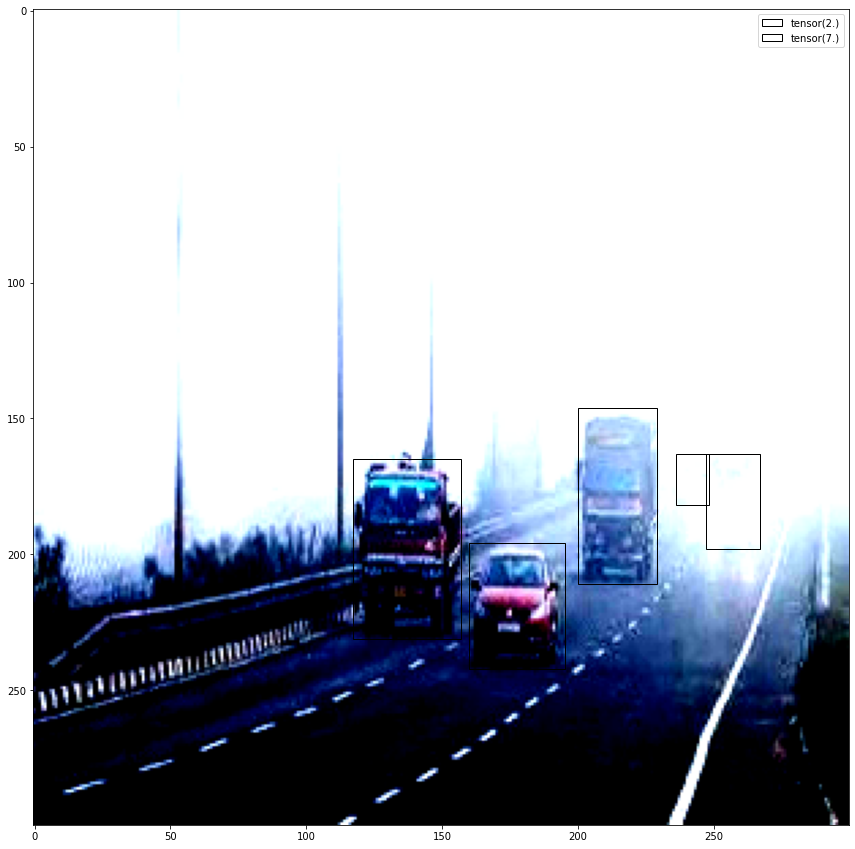

In [12]:
# Plot images
images, bboxes, labels = next(iter(valid_dataloader))
idx = 0
image, box, label = images[idx], bboxes[idx], labels[idx]
plot_image(image, box, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


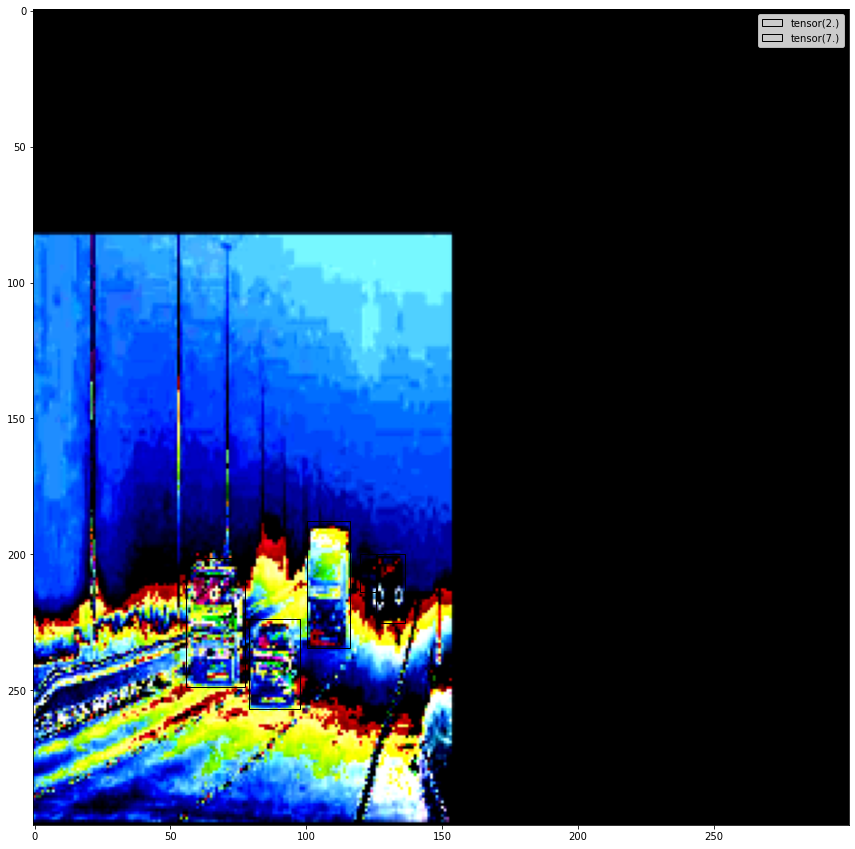

In [13]:
## Plot augmented images
image, box, label = transform_train(image, box, label)
plot_image(image, box, label)

Since the original images are relatively homogeneous, it's important that we augment the data so the model learns the properties of the extreme weather events rather than the structure of the weather patterns.

### Training!

In [14]:
### Helper functions
def clear_ram():
  gc.collect()
  torch.cuda.empty_cache()
  with torch.no_grad():
    torch.cuda.empty_cache()

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [15]:
def train(model, iterator, optimizer, criterion, box_coder):
  model.train()
  epoch_loss = 0

  for images, bboxes, labels in iterator:
    images = torch.stack(images).to(device)
    loc_targets, cls_targets = zip(*[box_coder.encode(bbox, label) for bbox, label in zip(bboxes, labels)])
    loc_targets = torch.stack(loc_targets).long().to(device)
    cls_targets = torch.stack(cls_targets).long().to(device)

    optimizer.zero_grad()
    loc_preds, cls_preds = model(images)
    loss = criterion(loc_preds, loc_targets, cls_preds, cls_targets)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    del loc_preds, cls_preds
    clear_ram()    
  
  return epoch_loss / len(iterator)

In [16]:
def evaluate(model, iterator, criterion, box_coder):
  model.eval()
  epoch_loss = 0

  with torch.no_grad():
    for images, bboxes, labels in iterator:
      images = torch.stack(images).to(device)
      loc_targets, cls_targets = zip(*[box_coder.encode(bbox, label) for bbox, label in zip(bboxes, labels)])
      loc_targets = torch.stack(loc_targets).long().to(device)
      cls_targets = torch.stack(cls_targets).long().to(device)
  
      loc_preds, cls_preds = model(images)
      loss = criterion(loc_preds, loc_targets, cls_preds, cls_targets)

      epoch_loss += loss.item()

      del loc_preds, cls_preds
      clear_ram()
    
  return epoch_loss / len(iterator)

In [17]:
if os.path.exists(prefix+'losses.txt'):
  with open(prefix+'losses.txt') as f:
    lines = f.readlines()
    train_loss, valid_loss = eval(lines[0]), eval(lines[1])
    best_loss = min(valid_loss)
else:
  train_loss, valid_loss = [], []
  best_loss = float('inf')

We save the model and losses because we need to run it for so many epochs (100 plus) before getting any meaningful results.

In [98]:
if os.path.exists(prefix+'model.pt'):
  model.load_state_dict(torch.load(prefix+'model.pt', map_location=device))

In [20]:
n_epochs = 0

for epoch in range(n_epochs):
  start = time.time()
  train_loss += [train(model, train_dataloader, optimizer, criterion, box_coder)]
  valid_loss += [evaluate(model, valid_dataloader, criterion, box_coder)]

  epoch_mins, epoch_secs = epoch_time(start, time.time())

  with open(prefix+'losses.txt', 'w') as f:
    f.write(str(train_loss)+'\n')
    f.write(str(valid_loss)+'\n')

  if valid_loss[-1] < best_loss:
    best_loss = valid_loss[-1]
    torch.save(model.state_dict(), prefix+'model.pt')

  print(f'\nEpoch #{epoch+1:02} Time: {epoch_mins}m {epoch_secs}s', end =' ')
  print(f'| Train Loss: {train_loss[-1]:.3f}', end=' ')
  print(f'| Valid Loss: {valid_loss[-1]:.3f}')

### Evaluation

In [165]:
model.load_state_dict(torch.load(prefix+'model.pt', map_location=device))
test_loss = evaluate(model, test_dataloader, criterion, box_coder)
print(f'\t Test Loss: {test_loss:.3f}')

	 Test Loss: 4.148


In [166]:
images, bboxes, labels = next(iter(valid_dataloader))
with torch.no_grad():
  images = torch.stack(images).to(device) 
  loc_targets, cls_targets = zip(*[box_coder.encode(bbox, label) for bbox, label in zip(bboxes, labels)])
  loc_preds, cls_preds = model(images)
  loc_preds = loc_preds.cpu()
  cls_preds = cls_preds.cpu()

In [178]:
def plot_images(images, bboxes, labels, loc_preds, cls_preds):
  num_images = images.shape[0]
  num_rows = 2*int(np.sqrt(num_images))
  num_cols = int(np.round(num_images//num_rows))
  fig, axs = plt.subplots(num_rows,num_cols, figsize=(15,30)) 
  fig.tight_layout()
  for i in range(0, num_rows,2):
    for j in range(num_cols):
      num = i*num_cols + j 
      if num < num_images:
        ax = axs[i,j]
        ax.imshow(torch.moveaxis(images[num], 0, -1))
        addbox(ax, bboxes[num], labels[num])
        ax = axs[i+1,j]
        pred_boxes, pred_labels, pred_scores = box_coder.decode(loc_preds[num], cls_preds[num])
        ax.imshow(torch.moveaxis(images[num], 0, -1))
        addbox(ax, pred_boxes, pred_labels)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

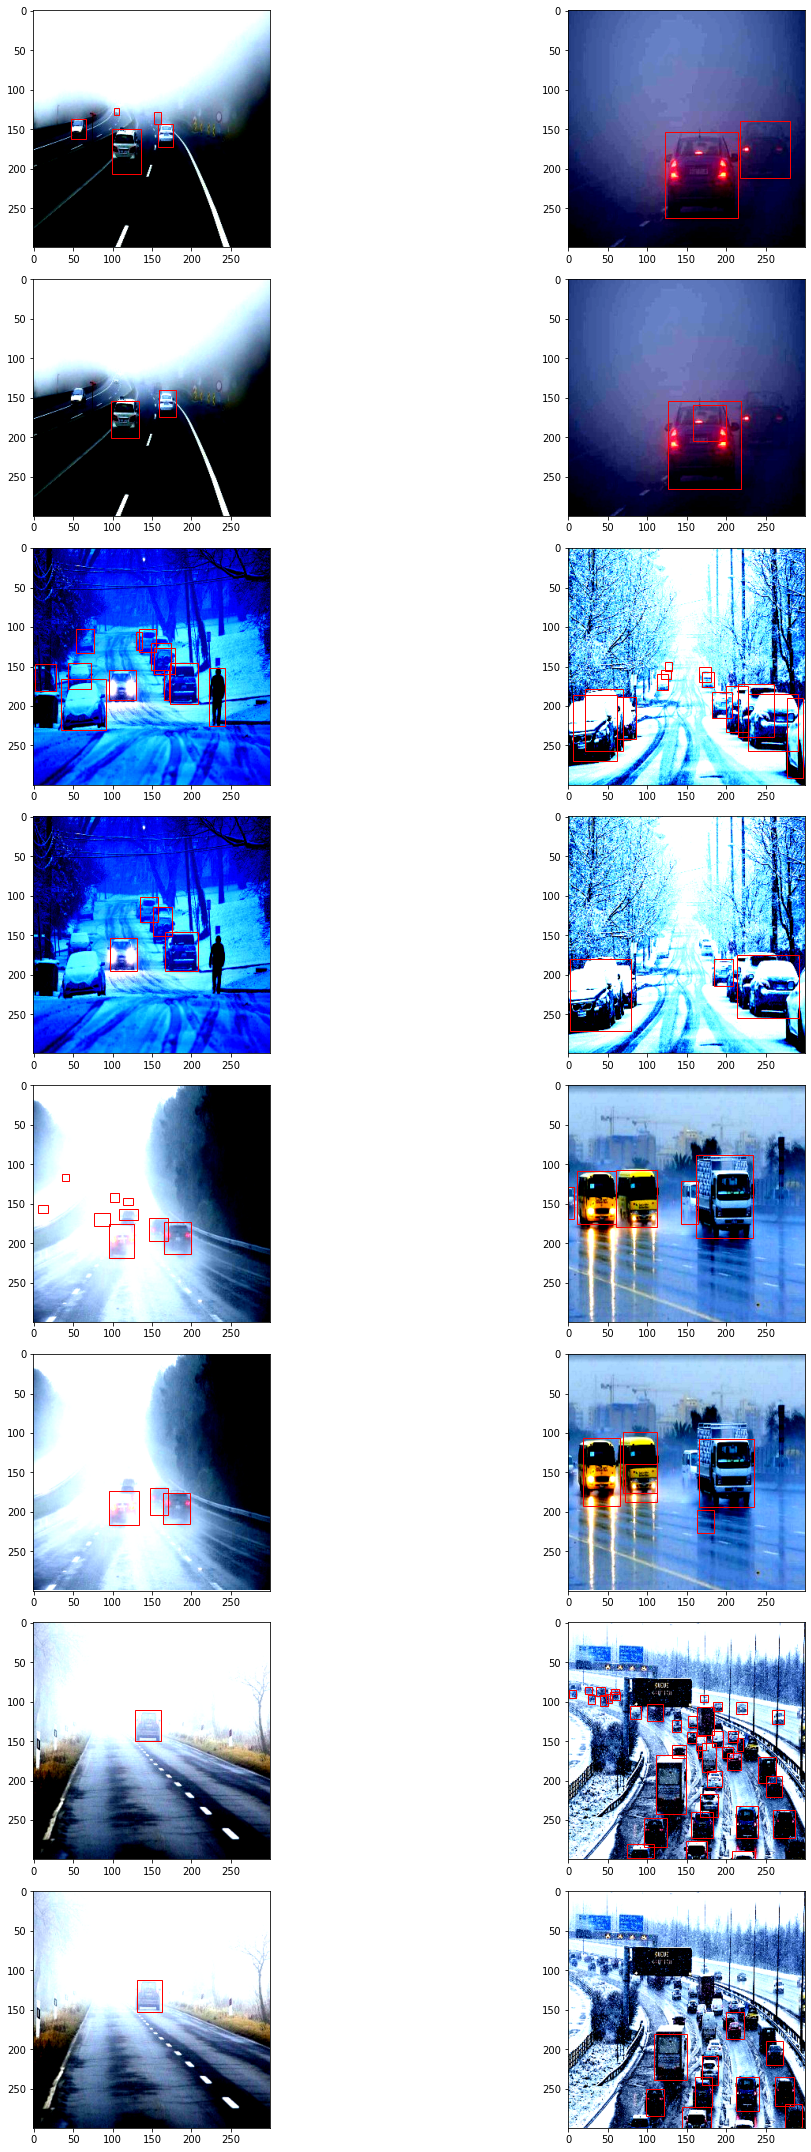

In [179]:
start, end = 0, 16
image = images[start:end].cpu()
plot_images(image, bboxes[start:end], labels[start:end], loc_preds, cls_preds)